In [2]:
import pandas as pd
import skfuzzy as fuzz
import numpy as np
from skfuzzy import control as ctrl
import matplotlib.pyplot as plt;

In [3]:
#LOAD DATASET
data_all = pd.read_pickle('choy_data.pkl')
data_all.head()

,heat index,humidity,moisture,soil_sens,temperature,wind,light,date,time
0,27.368090,72.0,38.599998,2077.600098,26.000000,12.553803,5.934079,2020-12-26,12:09:31
1,25.590635,73.0,37.900002,2083.399902,26.000000,13.458583,8.163333,2020-12-26,12:10:23
2,25.590635,72.0,37.900002,2085.699951,24.877772,3.153467,8.426666,2020-12-26,12:11:16
3,27.368090,72.0,38.299999,2085.300049,26.000000,13.910973,7.373333,2020-12-26,12:11:52
4,27.368090,72.0,38.099998,2077.600098,26.000000,12.044867,7.241666,2020-12-26,12:12:47


In [4]:
data = data_all.copy()
data = data[['humidity','temperature','heat index']]
data.head()

,humidity,temperature,heat index
0,72.0,26.000000,27.368090
1,73.0,26.000000,25.590635
2,72.0,24.877772,25.590635
3,72.0,26.000000,27.368090
4,72.0,26.000000,27.368090


### Data Cleaning

In [5]:

def identify_outliers(data):
    q1, q3 = data.quantile(0.25), data.quantile(0.75)
    iqr = q3 - q1
    cut_off = iqr * 1.5
    data_clean = data[~((data < (q1 - cut_off)) |(data > (q3 + cut_off))).any(axis=1)]
    return data_clean
data = identify_outliers(data)

In [6]:
#pd.plotting.scatter_matrix(data, diagonal='kde', figsize=(10,8) );

In [7]:
#graph4 = data.boxplot(grid=False,fontsize=12, figsize=(8, 6))
#fig4 = graph4.get_figure()
#fig4.savefig("boxplot2.png")

In [8]:
#def boxplt(data):
#    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex=True, figsize=(10,6))
#    axs = [ax1,ax2,ax3]
#    x = np.arange(data.shape[0])
#
#    for n in range(0,len(axs)):
#        axs[n].boxplot(data.iloc[:,n])
#        axs[n].set_title(data.columns[n])
#
#boxplt(data)

In [15]:
data.describe()

,humidity,temperature,heat
count,19717.000000,19717.000000,19717.000000
mean,76.485849,24.622391,25.099488
std,2.752027,0.543842,0.522000
min,68.000000,23.000000,23.300000
25%,75.000000,24.000000,24.500000
50%,76.000000,25.000000,25.500000
75%,79.000000,25.000000,25.500000
max,84.000000,26.000000,25.700000


## Data Sampling

In [9]:
data = data.rename(columns={'heat index': 'heat'})
data.heat=data.heat.round(1)
#hhdata.to_pickle('data_hth.pkl')

In [10]:
#DIVIDE DATASET
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(data, test_size=0.3, random_state=1)

## Model Development

In [11]:
def get_range(data):
    data_range = pd.DataFrame(columns = data.columns, index = ['max', 'min'])
    data_range.loc['max'] = [data[col].max() for col in data.columns]
    data_range.loc['min'] = [data[col].min() for col in data.columns]
    return data_range

range_df = get_range(data)
range_df

,humidity,temperature,heat
max,84,26,25.7
min,68,23,23.3


In [12]:
#SPECIFY UNIVERSE OF DISCOURSE
universe = []
for col in range_df.columns:
        universe_col = np.arange(np.floor(range_df[col].min()), np.ceil(range_df[col].max()+1), 0.1)
        universe.append(universe_col)

In [13]:
# MEDIAN FUNCTION
def med(l, u):
    return np.median(np.arange(l, u, 0.1))

C:\Python\lib\site-packages\skfuzzy\control\fuzzyvariable.py:122: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Python\lib\site-packages\skfuzzy\control\fuzzyvariable.py:122: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Python\lib\site-packages\skfuzzy\control\fuzzyvariable.py:122: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


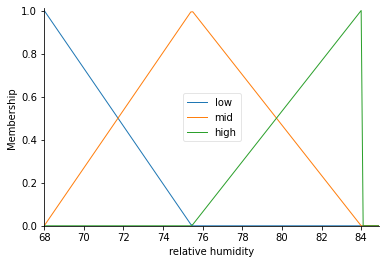

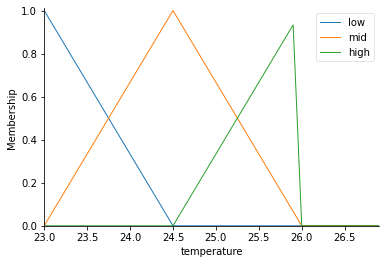

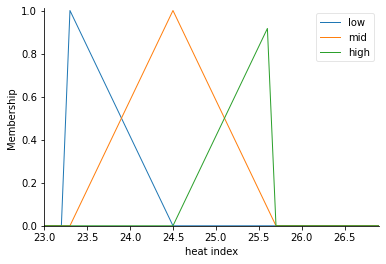

In [16]:

#Visualie membership fn

humidity = ctrl.Antecedent(universe[0], 'relative humidity')
temperature = ctrl.Antecedent(universe[1], 'temperature')
heat = ctrl.Consequent(universe[2], 'heat index')

#BUILD MEMBERSHIP FUNCTIONS
humidity['low'] =     fuzz.trimf(universe[0], [68, 68, med(68,83)])
humidity['mid'] =     fuzz.trimf(universe[0], [68, med(68,83), 84])
humidity['high'] =     fuzz.trimf(universe[0], [med(68,83), 84, 84])

temperature['low'] =  fuzz.trimf(universe[1],  [23, 23, med(23.1,26)])
temperature['mid'] =  fuzz.trimf(universe[1],  [23, med(23.1,26), 26])
temperature['high'] =  fuzz.trimf(universe[1], [med(23.1,26), 26, 26])
 
heat['low'] =         fuzz.trimf(universe[2],  [23.3, 23.3, med(23.3,25.8)])
heat['mid'] =         fuzz.trimf(universe[2],  [23.3, med(23.3,25.8), 25.7])
heat['high'] =         fuzz.trimf(universe[2], [med(23.3,25.8), 25.7, 25.7])

for i in range(1):
    humidity.view()
    temperature.view() 
    heat.view()

In [87]:
hum_lo  = fuzz.trimf(universe[0], [68, 68, med(68,83)])
hum_mid = fuzz.trimf(universe[0], [68, med(68,83), 84])
hum_hi  =  fuzz.trimf(universe[0], [med(68,83), 84, 84])

temp_lo  = fuzz.trimf(universe[1], [23, 23, med(23,26.1)])
temp_mid = fuzz.trimf(universe[1], [23, med(23,26.1), 26])
temp_hi  = fuzz.trimf(universe[1], [med(23,26.1), 26, 26])


heat_lo  = fuzz.trimf(universe[2], [23.3, 23.3, med(23.3,25.8)])
heat_mid = fuzz.trimf(universe[2], [23.3, med(23.3,25.8), 25.7])
heat_hi  = fuzz.trimf(universe[2], [med(23.3,25.8), 25.7, 25.7])

In [96]:
med(23.1, 26)

24.50000000000002

In [16]:
range_df

,humidity,temperature,heat
max,84,26,25.7
min,68,23,23.3


In [18]:
#FUZZIFY  TRAIN SET HUMIDITY
def fuzzify_hum(hum_val):
    hum_df = pd.DataFrame(hum_val)
    hum_df['low'] = fuzz.interp_membership(universe[0], hum_lo, hum_val)
    hum_df['mid'] = fuzz.interp_membership(universe[0], hum_mid, hum_val)
    hum_df['high'] = fuzz.interp_membership(universe[0], hum_hi, hum_val)

    hum_df['membership'] = hum_df.loc[:, ['low', 'mid', 'high']].idxmax(axis = 1)
    hum_df['degree'] = hum_df.loc[:, ['low', 'mid', 'high']].max(axis = 1)
    return hum_df

hum_val = train_data.iloc[:,0]
hum_df = fuzzify_hum(hum_val)
hum_df

,humidity,low,mid,high,membership,degree
6101,74.0,0.194631,0.805369,0.000000,mid,0.805369
9966,76.0,0.000000,0.935673,0.064327,mid,0.935673
14034,79.0,0.000000,0.584795,0.415205,mid,0.584795
21924,77.0,0.000000,0.818713,0.181287,mid,0.818713
14190,76.0,0.000000,0.935673,0.064327,mid,0.935673
...,...,...,...,...,...,...
13762,83.0,0.000000,0.116959,0.883041,high,0.883041
20724,77.0,0.000000,0.818713,0.181287,mid,0.818713
6495,74.0,0.194631,0.805369,0.000000,mid,0.805369
15192,80.0,0.000000,0.467836,0.532164,high,0.532164


In [19]:
hum_df.groupby(by='membership')['membership'].count()

membership
high     2579
low       417
mid     10805
Name: membership, dtype: int64

In [1]:
#FUZZIFY TRAIN SET TEMPERATURE
 
def fuzzify_temp(temp_val):
    temp_df = pd.DataFrame(temp_val)
    temp_df['low'] = fuzz.interp_membership(universe[1], temp_lo, temp_val)
    temp_df['mid'] = fuzz.interp_membership(universe[1], temp_mid, temp_val)
    temp_df['high'] = fuzz.interp_membership(universe[1], temp_hi, temp_val)

    temp_df['membership'] = temp_df.loc[:, ['low', 'mid', 'high']].idxmax(axis = 1)
    temp_df['degree'] = temp_df.loc[:, ['low', 'mid', 'high']].max(axis = 1)
    return temp_df
temp_val  = train_data.iloc[:,1]       
temp_df = fuzzify_temp(temp_val)
temp_df;

NameError: name 'train_data' is not defined

In [21]:
temp_df.groupby(by='membership')['membership'].count()

membership
high      433
low        10
mid     13358
Name: membership, dtype: int64

In [22]:
#FUZZIFY TRAIN SET LIGHT INTENSITY
def fuzzify_heat(heat_val):
    heat_df = pd.DataFrame(heat_val)
    heat_df['low'] = fuzz.interp_membership(universe[2], heat_lo, heat_val)
    heat_df['mid'] = fuzz.interp_membership(universe[2], heat_mid,heat_val)
    heat_df['high'] = fuzz.interp_membership(universe[2],heat_hi, heat_val)

    heat_df['membership'] = heat_df.loc[:, ['low', 'mid', 'high']].idxmax(axis = 1)
    heat_df['degree'] = heat_df.loc[:, ['low', 'mid', 'high']].max(axis = 1)
    return heat_df
heat_val = train_data.iloc[:,2]
heat_df = fuzzify_heat(heat_val)
heat_df;

In [23]:
heat_df.groupby(by='membership')['membership'].count()

membership
high    8194
low       10
mid     5597
Name: membership, dtype: int64

In [24]:
# Merge the membership columns from predictors and target to get an initial rule set
#----convert numerical values to linguistic values


def merge_rule(df, hum_df, temp_df, heat_df):
    rule_df = df.copy()
    rule_df['humidity'] = hum_df['membership']
    rule_df['temperature'] = temp_df['membership']
    rule_df['heat'] = heat_df['membership']
    rule_df['degree'] = hum_df['degree']*temp_df['degree']*heat_df['degree']
    return rule_df
 
rule_df = merge_rule(train_data, hum_df, temp_df, heat_df)
rule_df;

In [25]:
train_data;

In [26]:
#Resolve conflicts to get a final rule set

rule_fuzzy = rule_df.groupby(['humidity', 'temperature']).max()
rule_fuzzy = rule_fuzzy.reset_index()
rule_fuzzy_deg = rule_fuzzy.pop('degree')
rule_fuzzy
rule_fuzzy.to_pickle('frule.pkl')

In [27]:
rule_fuzzy

,humidity,temperature,heat
0,high,low,low
1,high,mid,mid
2,low,mid,mid
3,mid,high,high
4,mid,low,low
5,mid,mid,mid


In [28]:
frule_pvt = rule_fuzzy.pivot(index='temperature', columns='humidity', values='heat')
frule_pvt

humidity,high,low,mid
temperature,,,
high,NaN,NaN,high
low,low,NaN,low
mid,mid,mid,mid


## Predictive Modelling
  

In [29]:
#SET UP TEST DATA

test_data.reset_index(drop=True, inplace=True)
y_test = test_data.loc[:,'heat']
test_data.to_pickle('test_data.pkl')

In [30]:
#FUZZIFY TEST SET HUMIDITY VALUES

test_hum_val = test_data.iloc[:,0]
test_hum_df = fuzzify_hum(test_hum_val)
test_hum_df;

In [31]:
#FUZZIFY TEST TEMPERATURE VALUES

test_temp_val = test_data.iloc[:,1]
test_temp_df = fuzzify_temp(test_temp_val)
test_temp_df;

In [32]:
#best score 0.5, 0.9, 0.0

In [33]:
#DEFINE THE CENTER OF THE FUZZY REGIONS FOR TEMPERATURE

def fuzzr_center(a):
    if a == 'low':
        return range_df.loc['min','heat']-0.6
    if a == 'mid':
        return med(range_df.loc['min','heat'], range_df.loc['max','heat'])+1
    if a == 'high':
        return range_df.loc['max','heat']+0.0
fuzzr_center('mid')

25.450000000000017

In [34]:
#PASS TEST DATA THROUGH EACH RULE AND AGGREGATE OUTPUT

ynum = np.zeros([y_test.shape[0], rule_fuzzy.shape[0]])
ydenom = np.zeros([y_test.shape[0], rule_fuzzy.shape[0]])
for i, fser in test_data.iterrows():
    for j, rser in rule_fuzzy.iterrows():
        col = rser.values
        rule_acx_num =test_hum_df.loc[i,col[0]] * test_temp_df.loc[i,col[1]]*fuzzr_center(col[2])
        rule_acx_denom =test_hum_df.loc[i,col[0]]*test_temp_df.loc[i,col[1]]
        ynum[i,j] = rule_acx_num
        ydenom[i,j] = rule_acx_denom

In [35]:
#COMPUTE THE PREDICTED TEMPERATURE
sum_ynum = np.sum(ynum, axis=1)
sum_ydenom = np.sum(ydenom, axis=1)
y_pred = sum_ynum/sum_ydenom
y_pred

array([24.47419355, 25.51650246, 25.52407407, ..., 24.47419355,
       25.52429245, 25.49864865])

## Model Evaluation

In [36]:
from sklearn.metrics import r2_score, mean_squared_error
model_r2 = r2_score(y_test, y_pred)
model_mse = mean_squared_error(y_test, y_pred)
print('$R^2$', model_r2)
print('RMSE: ', np.sqrt(model_mse))

$R^2$ 0.9740261121057313
RMSE:  0.0842211160984931


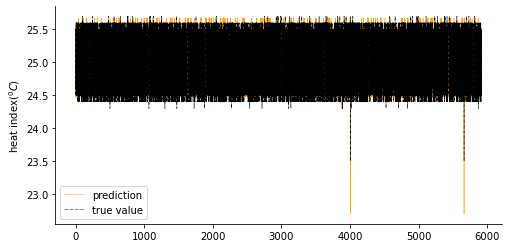

In [73]:
plt.figure(figsize=(8,4))
plt.plot(y_pred, linewidth=0.5, color='orange', label='prediction')
plt.plot(y_test, linewidth=0.5, linestyle='-.', color='black', label='true value')
plt.ylabel('heat index($^0C$)')
plt.legend(loc='lower left')
#plt.delaxes('top')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.savefig('heat_time_series.png')

## Performance Comparison

In [38]:
# SET UP TRAIN DATA

X_train = train_data.copy()
y_train = X_train.pop('heat')
X_train.to_numpy()
y_train.to_numpy()

array([25.5, 25.5, 25.6, ..., 25.5, 24.5, 25.5])

In [39]:
#SET UP TEST DATA

X_test = test_data.copy()
y_test = X_test.pop('heat')
X_test.to_numpy()
y_test.to_numpy()

array([24.5, 25.5, 25.5, ..., 24.5, 25.5, 25.4])

In [40]:
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor

In [41]:
model_names = ['Dummy', 'Linear', 'Lasso', 'Random Forest']

models = [
    DummyRegressor(strategy='median'),
    LinearRegression(fit_intercept=False),
    Lasso(fit_intercept=False),
    RandomForestRegressor(n_estimators=50, n_jobs=-1)
    ]

In [42]:
for name, model in zip(model_names, models):
    model.fit(X_train, y_train)
    y_predd=model.predict(X_test)
    print(name, r2_score(y_test, y_predd))
    print(np.sqrt(mean_squared_error(y_test, y_predd)))
    

Dummy -0.5877716486098139
0.6584859803686967
Linear 0.917549749906729
0.15005431899227006
Lasso -0.33868707436049283
0.604633278321568
Random Forest 1.0
1.72154030752562e-13


In [43]:
y_pred = y_pred.reshape(-1, 1)
from sklearn.feature_selection import chi2, f_regression
f_stat = f_regression(y_pred, y_test)
f_stat

(array([222900.85730462]), array([0.]))

In [54]:
#Percent error
mean_hi = y_test.mean()
rmse = np.sqrt(model_mse)
percent_err = (rmse/mean_hi)*100
percent_err

0.33555088218606705

In [52]:
0.1/mean_hi*100

0.39841657025021393

In [53]:
model_r2

0.9740261121057313

In [62]:
#hi = pd.DataFrame(y_test)
#hi['prediction'] = y_pred
#hi.rename(columns = {'heat': 'true value'}, inplace=True)
#hi.head()

In [61]:
#hi_box = hi.boxplot(grid=False,fontsize=12, figsize=(8, 6))
#hi_fig = hi_box.get_figure()
#fig4.savefig("boxplot2.png")

In [45]:
#res = y_test - y_pred
#plt.scatter(y_pred, res, color='black')
#plt.axhline(linewidth=2, color='grey')

In [46]:
#plt.hist(res, 50, facecolor='black');
#
#plt.xlabel('Residual')
#plt.ylabel('Frequency')

In [47]:
#from pandas.plotting import table 
#
#hi_hum = data[data.humidity==data.humidity.max()]
#
#fig = plt.figure(figsize=(8, 12))
##ax = plt.subplot(111, frame_on=False) 
##ax.xaxis.set_visible(False) 
##ax.yaxis.set_visible(False)  
#ax.table(cellText=hi_hum.values, cellLoc='center', colLabels=['Relative humidity', 'Temperature', 'Heat Index']) 
#plt.show()
##plt.savefig('hi_hum.jpg')
#

In [50]:
#def chi_square(obs, exp):
#    chi2 = 0
#    for i in range(obs.shape[0]):
#        chii = (obs[i]-exp[i])**2/exp[i]
#        chi2 += chii
#chi_square()